# Evaluation

Now that we have a finetuned Model, let's see if we can get a better performance regarding the similarity between the captions.

In [36]:
# fix locale, to prevent future flaky errors

import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install diffusers
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
# import libraries

import os
import torch
import numpy as np
import gensim.downloader


from diffusers import StableDiffusionPipeline
from PIL import Image
from scipy.spatial.distance import cosine
from transformers import BlipProcessor, BlipForConditionalGeneration

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 6>:6                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/gensim/__init__.py:11 in <module>                        │
│                                                                                                  │
│    8                                                                                             │
│    9 import logging                                                                              │
│   10                                                                                             │
│ ❱ 11 from gensim import parsing, corpora, matutils, interfaces, models, similarities, utils      │
│   12                                                                                             │
│   13                                                                                             │
│   14 logger = logging.getLogger('gensim')                                                        │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/gensim/parsing/__init__.py:4 in <module>                 │
│                                                                                                  │
│    1 """This package contains functions to preprocess raw text"""                                │
│    2                                                                                             │
│    3 from .porter import PorterStemmer  # noqa:F401                                              │
│ ❱  4 from .preprocessing import (  # noqa:F401                                                   │
│    5 │   preprocess_documents,                                                                   │
│    6 │   preprocess_string,                                                                      │
│    7 │   read_file,                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/gensim/parsing/preprocessing.py:26 in <module>           │
│                                                                                                  │
│    23 import string                                                                              │
│    24 import glob                                                                                │
│    25                                                                                            │
│ ❱  26 from gensim import utils                                                                   │
│    27 from gensim.parsing.porter import PorterStemmer                                            │
│    28                                                                                            │
│    29                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/gensim/utils.py:37 in <module>                           │
│                                                                                                  │
│     34                                                                                           │
│     35 import numpy as np                                                                        │
│     36 import scipy.sparse                                                                       │
│ ❱   37 from smart_open import open                                                               │
│     38                                                     

In [4]:
# create folders if they don't exist already

folder_names = ['embeddings', 'images', 'models']

# check and create folders if they don't exist
for folder_name in folder_names:
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created.")
    else:
        print(f"Folder '{folder_name}' already exists.")

Folder 'embeddings' created.
Folder 'images' created.
Folder 'models' created.


To get the finetuned model in this notebook the easiest way ist to get the training weights by cloning this github repo itself.

In [5]:
!git clone https://github.com/raschnick/ml2_project_x.git

Cloning into 'ml2_project_x'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 59 (delta 20), reused 21 (delta 5), pack-reused 0
Unpacking objects: 100% (59/59), 27.32 MiB | 8.62 MiB/s, done.


Now we can create the Model Pipeline with the weights. We take the model with the 50 training epochs here, since it performed the best in the comparison between the 3 training attempts. Which isn't exactly a surprise to be fair.

In [12]:
pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4', torch_dtype=torch.float16)
pipe.unet.load_attn_procs('./ml2_project_x/model_weights/pytorch_lora_weights_50_epochs.bin')
pipe.to('cuda')

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.16.1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

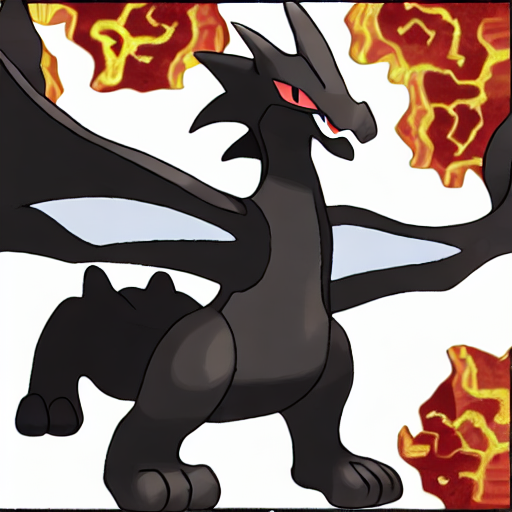

In [27]:
image = pipe(prompt='a black dragon with fire').images[0]
image.save('images/test_image.png')
image.show()

This looks very cool, but now let's see how it performs if we compare multiple images via the pipeline. For this we can use the method that we wrote before, including the other helper functions and the google news word embedding:

In [35]:
# Set up BLIP model

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")

# Download Google News Word Embedding. If it's downloaded already it won't do it again!

embedding_path = 'embeddings/word2vec-google-news-300.bin'
embedding_name = 'word2vec-google-news-300'

if os.path.exists(embedding_path):
    print("Word Embedding has been downloaded already.")
else:
  google_news_embedding = gensim.downloader.load(embedding_name)
  google_news_embedding.save(embedding_path)

google_news_word_embedding = gensim.models.KeyedVectors.load(embedding_path)

def get_mean_vector(sentence, word_embedding):
  tokens = sentence.split()
  embedding = [word_embedding[word] for word in tokens if word in word_embedding]

  if len(embedding) > 0:
    return np.mean(embedding, axis=0)
  else:
    return None

def calculate_mv_similarity(sentence_1_mv, sentence_2_mv):
  if sentence_1_mv is not None and sentence_2_mv is not None:
    similarity = 1 - cosine(sentence_1_mv, sentence_2_mv)
    return similarity
  else:
    return None

def run_pipeline_no_print(initial_caption, word_embedding):
  image1 = pipe(initial_caption).images[0]
  image1.save('images/image.png')

  raw_image = Image.open('images/image.png').convert('RGB')
  inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)
  out = model.generate(**inputs)
  image1_caption = processor.decode(out[0], skip_special_tokens=True)

  initial_caption_mv = get_mean_vector(initial_caption, word_embedding)
  image1_caption_mv = get_mean_vector(image1_caption, word_embedding)

  return calculate_mv_similarity(initial_caption_mv, image1_caption_mv)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/gensim/__init__.py:11 in <module>                        │
│                                                                                                  │
│    8                                                                                             │
│    9 import logging                                                                              │
│   10                                                                                             │
│ ❱ 11 from gensim import parsing, corpora, matutils, interfaces, models, similarities, utils      │
│   12                                                                                             │
│   13                                                                                             │
│   14 logger = logging.getLogger('gensim')                                                        │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/gensim/parsing/__init__.py:4 in <module>                 │
│                                                                                                  │
│    1 """This package contains functions to preprocess raw text"""                                │
│    2                                                                                             │
│    3 from .porter import PorterStemmer  # noqa:F401                                              │
│ ❱  4 from .preprocessing import (  # noqa:F401                                                   │
│    5 │   preprocess_documents,                                                                   │
│    6 │   preprocess_string,                                                                      │
│    7 │   read_file,                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/gensim/parsing/preprocessing.py:26 in <module>           │
│                                                                                                  │
│    23 import string                                                                              │
│    24 import glob                                                                                │
│    25                                                                                            │
│ ❱  26 from gensim import utils                                                                   │
│    27 from gensim.parsing.porter import PorterStemmer                                            │
│    28                                                                                            │
│    29                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/gensim/utils.py:37 in <module>                           │
│                                                                                                  │
│     34                                                                                           │
│     35 import numpy as np                                                                        │
│     36 import scipy.sparse                                                                       │
│ ❱   37 from smart_open import open                                                               │
│     38                                                     

### Conclusions 

#### Further possible improvements:

* Problem with black NSFW images? How prevelant is this? TODO.
* Use a different word embedding. Ideally there would be a matching word embedding. For example [Poke2Vec](https://www.smogon.com/forums/threads/poke2vec-vector-embeddings-of-pokemon.3665786/). Important to note is that  our finetuning does not use the names of Pokemons.
* Finetune the BLIP model, also with Pokemon data.
* Use all the methods with a different approach, maybe you could generate comics only, or something similar.


